#### TestUse.ipynb

**Objective:** Rebuild the `FuzzyInferenceSystem` architecture from fuzzyR using Python and PyTorch to implement a basic fuzzy inference engine.

This notebook proceeds step-by-step:
1. Environment and dependency validation  
2. Definition of the `FuzzyInferenceSystem` class  
3. Core `eval()` inference workflow  
4. Basic input testing  

Later, each component will be modularized into Python files under the `src/` directory.


In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys, os

print("Python interpreter path:", sys.executable)
print("Torch version:", torch.__version__)
print("Numpy version:", np.__version__)


Python interpreter path: c:\Users\admin\Desktop\fuzzyinferencesystem\fuzzy-gradient-optimisation\.venv\Scripts\python.exe
Torch version: 2.9.0+cpu
Numpy version: 2.3.4


#### FuzzyInferenceSystem Class Structure

In fuzzyR, a FIS (Fuzzy Inference System) object consists of:
- Input and output variables (each with membership functions)
- A rule base (if–then rules)
- Inference and aggregation methods (e.g., min, max, prod)

We first build a Python version of this structural framework.


In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


class FuzzyInferenceSystem:
    """
    Python reimplementation of FuzzyR::fuzzyinferencesystem.R
    Logical order: newfis() → addvar() → addmf() → addrule() → evalfis() + defuzz()
    """

    def __init__(self, name, fis_type="mamdani", mf_type="t1",
                 and_method="min", or_method="max", imp_method="min",
                 agg_method="max", defuzz_method="centroid"):
        """Equivalent to fuzzyR::newfis()"""
        self.name = name
        self.type = fis_type
        self.mf_type = mf_type
        self.and_method = and_method
        self.or_method = or_method
        self.imp_method = imp_method
        self.agg_method = agg_method
        self.defuzz_method = defuzz_method
        self.input = []
        self.output = []
        self.rule = []
        print(f"Created FIS: {self.name} (type={self.type})")

    # --------------------------------------------------------------
    # addvar()
    # --------------------------------------------------------------
    def add_variable(self, var_type, name, var_range, method=None, params=None, firing_method="tnorm.min.max"):
        variable = {
            "name": name,
            "range": list(var_range),
            "method": method,
            "params": params,
            "mf": [],
            "firing_method": firing_method
        }
        if var_type == "input":
            self.input.append(variable)
        elif var_type == "output":
            self.output.append(variable)
        else:
            raise ValueError("var_type must be 'input' or 'output'")
        print(f"Added {var_type}: {name} range={var_range}")

    # --------------------------------------------------------------
    # addmf()
    # --------------------------------------------------------------
    def add_mf(self, var_type, var_index, mf_name, mf_type, mf_params):
        mf_data = {"name": mf_name, "type": mf_type, "params": mf_params}
        if var_type == "input":
            self.input[var_index]["mf"].append(mf_data)
        elif var_type == "output":
            self.output[var_index]["mf"].append(mf_data)
        else:
            raise ValueError("var_type must be 'input' or 'output'")
        print(f"Added MF '{mf_name}' ({mf_type}) to {var_type}[{var_index}]")

    # --------------------------------------------------------------
    # addrule()
    # --------------------------------------------------------------
    def add_rule(self, rule_list):
        self.rule.append(rule_list)
        print(f"Added rule: {rule_list}")

    # --------------------------------------------------------------
    # showrule()
    # --------------------------------------------------------------
    def show_rules(self):
        if not self.rule:
            print("No rules defined.")
            return
        print("=== Rule Base ===")
        for i, r in enumerate(self.rule, 1):
            print(f"{i}. Rule: {r}")
        print("=================")

    # --------------------------------------------------------------
    # evalmf()
    # --------------------------------------------------------------
    def evalmf(self, x, mf_type, params):
        x = torch.tensor(x, dtype=torch.float32)
        if mf_type == "gaussmf":
            sigma, c = params
            return torch.exp(-((x - c) ** 2) / (2 * sigma ** 2))
        elif mf_type == "gbellmf":
            a, b, c = params
            return 1 / (1 + ((torch.abs((x - c) / a)) ** (2 * b)))
        elif mf_type == "trimf":
            a, b, c = params
            return torch.clamp(torch.minimum((x - a) / (b - a),
                                             (c - x) / (c - b)), 0, 1)
        elif mf_type == "trapmf":
            a, b, c, d = params
            y1 = (x - a) / (b - a)
            y2 = torch.ones_like(x)
            y3 = (d - x) / (d - c)
            y = torch.minimum(torch.minimum(y1, y2), y3)
            return torch.clamp(y, 0, 1)
        elif mf_type == "sigmf":
            a, c = params
            return 1 / (1 + torch.exp(-a * (x - c)))
        elif mf_type == "smf":
            a, b = params
            y = torch.zeros_like(x)
            idx1 = x <= a
            idx2 = (x > a) & (x < (a + b) / 2)
            idx3 = (x >= (a + b) / 2) & (x < b)
            idx4 = x >= b
            y[idx2] = 2 * ((x[idx2] - a) / (b - a)) ** 2
            y[idx3] = 1 - 2 * ((x[idx3] - b) / (b - a)) ** 2
            y[idx4] = 1
            return y
        elif mf_type == "zmf":
            a, b = params
            y = torch.zeros_like(x)
            idx1 = x <= a
            idx2 = (x > a) & (x < (a + b) / 2)
            idx3 = (x >= (a + b) / 2) & (x < b)
            idx4 = x >= b
            y[idx1] = 1
            y[idx2] = 1 - 2 * ((x[idx2] - a) / (b - a)) ** 2
            y[idx3] = 2 * ((x[idx3] - b) / (b - a)) ** 2
            return y
        elif mf_type == "pimf":
            a, b, c, d = params
            smf_part = self.evalmf(x, "smf", [a, b])
            zmf_part = self.evalmf(x, "zmf", [c, d])
            return torch.minimum(smf_part, zmf_part)
        else:
            raise NotImplementedError(f"MF type '{mf_type}' not implemented.")

    # --------------------------------------------------------------
    # evalfis()
    # --------------------------------------------------------------
    def eval(self, inputs, point_n=101):
        print("=== Starting FIS Evaluation ===")
        x = torch.tensor(inputs, dtype=torch.float32).flatten()

        # ---- Step 1: Fuzzification ----
        input_mfs = []
        for i, var in enumerate(self.input):
            var_mf_vals = []
            for mf in var["mf"]:
                mu = self.evalmf(x[i], mf["type"], mf["params"])
                var_mf_vals.append(mu)
            input_mfs.append(var_mf_vals)

        # ---- Step 2: Rule evaluation ----
        rule_strengths = []
        for rule in self.rule:
            antecedents = []
            for j in range(len(self.input)):
                val = rule[j]
                if val == 0:
                    continue
                mf_idx = abs(val) - 1
                mu = input_mfs[j][mf_idx]
                if val < 0:
                    mu = 1 - mu
                antecedents.append(mu)
            firing = torch.min(torch.stack(antecedents)) if rule[-1] == 1 else torch.max(torch.stack(antecedents))
            firing *= float(rule[-2])
            rule_strengths.append(firing)

        # ---- Step 3: Aggregation ----
        y = torch.linspace(self.output[0]["range"][0], self.output[0]["range"][1], point_n, dtype=torch.float32)
        agg_mu = torch.zeros_like(y)

        for rule, firing in zip(self.rule, rule_strengths):
            out_idx = abs(rule[len(self.input)]) - 1
            out_mf = self.output[0]["mf"][out_idx]
            mu = self.evalmf(y, out_mf["type"], out_mf["params"])

            # Implication
            if self.imp_method == "min":
                mu = torch.minimum(mu, torch.tensor(firing))
            elif self.imp_method == "prod":
                mu = mu * firing
            else:
                raise NotImplementedError(f"Implication method '{self.imp_method}' not implemented.")

            # Aggregation
            if self.agg_method == "max":
                agg_mu = torch.maximum(agg_mu, mu)
            elif self.agg_method == "sum":
                agg_mu = torch.clamp(agg_mu + mu, 0, 1)
            else:
                raise NotImplementedError(f"Aggregation method '{self.agg_method}' not implemented.")

        # ---- Step 4: Defuzzification ----
        crisp_output = self.defuzz(y, agg_mu, self.defuzz_method)
        print("=== Evaluation Completed ===")
        return crisp_output

    # --------------------------------------------------------------
    # defuzz()
    # --------------------------------------------------------------
    def defuzz(self, x, mf, method="centroid"):
        x, mf = x.detach(), mf.detach()
        if method == "centroid":
            s = torch.sum(mf)
            return (torch.sum(mf * x) / s).item() if s > 0 else torch.mean(x).item()
        elif method == "bisector":
            cs, total = torch.cumsum(mf, dim=0), torch.sum(mf)
            if total == 0: return torch.mean(x).item()
            half = total / 2
            idx = torch.nonzero(cs > half, as_tuple=True)[0][0]
            return x[0].item() if idx == 0 else ((x[idx - 1] + x[idx]) / 2.0).item()
        elif method == "mom":
            maxv, idx = torch.max(mf), torch.nonzero(mf == torch.max(mf), as_tuple=True)[0]
            return torch.mean(x[idx]).item()
        elif method == "som":
            idx = torch.nonzero(mf == torch.max(mf), as_tuple=True)[0]
            return x[idx[0]].item()
        elif method == "lom":
            idx = torch.nonzero(mf == torch.max(mf), as_tuple=True)[0]
            return x[idx[-1]].item()
        else:
            raise NotImplementedError(f"Defuzzification method '{method}' not implemented.")

    # --------------------------------------------------------------
    # summary()
    # --------------------------------------------------------------
    def summary(self):
        print("=== Fuzzy Inference System Summary ===")
        print(f"Name: {self.name}")
        print(f"Type: {self.type}")
        print(f"Inputs: {len(self.input)}")
        print(f"Outputs: {len(self.output)}")
        print(f"Rules: {len(self.rule)}")
        print(f"Defuzz Method: {self.defuzz_method}")
        print("======================================")

    # --------------------------------------------------------------
    # plotmf() — 绘制输入或输出变量的隶属函数
    # --------------------------------------------------------------
    def plotmf(self, var_type="input", var_index=0, point_n=201, main=None):
        if var_type not in ["input", "output"]:
            raise ValueError("var_type must be 'input' or 'output'")

        var_list = self.input if var_type == "input" else self.output
        if var_index >= len(var_list):
            raise IndexError(f"{var_type}[{var_index}] does not exist")

        var = var_list[var_index]
        var_range = var["range"]
        x = torch.linspace(var_range[0], var_range[1], point_n).numpy()

        plt.figure(figsize=(5, 3))
        for mf in var["mf"]:
            params = np.array(mf["params"])
            if mf["type"] == "gaussmf":
                sigma, c = params
                mu = np.exp(-((x - c) ** 2) / (2 * sigma ** 2))
            else:
                raise NotImplementedError(f"MF type '{mf['type']}' not supported in plotmf()")
            plt.plot(x, mu, label=mf["name"], linewidth=2)

        plt.title(main or f"{var_type.capitalize()} {var['name']} MFs")
        plt.xlabel(var["name"])
        plt.ylabel("Membership degree")
        plt.legend()
        plt.grid(True)
        plt.show()

    # --------------------------------------------------------------
    # plotvar() — 可视化输入对输出的模糊关系
    # --------------------------------------------------------------
    def plotvar(self, input_index=0, point_n=101):
        if len(self.input) == 0 or len(self.output) == 0:
            raise RuntimeError("FIS must have at least one input and one output.")
        if len(self.input) > 1:
            print("Warning: plotvar() currently supports single-input systems only.")

        var = self.input[input_index]
        x = np.linspace(var["range"][0], var["range"][1], point_n)
        y = [self.eval([v], point_n=point_n) for v in x]

        plt.figure(figsize=(5, 3))
        plt.plot(x, y, color="blue", linewidth=2)
        plt.title(f"Fuzzy Relationship: {var['name']} → {self.output[0]['name']}")
        plt.xlabel(var["name"])
        plt.ylabel(self.output[0]["name"])
        plt.grid(True)
        plt.show()

        # --------------------------------------------------------------
    # plot_graph() — 绘制模糊系统结构图
    # --------------------------------------------------------------
    def plot_graph(self):
        G = nx.DiGraph()
        input_nodes = [f"Input: {v['name']}" for v in self.input]
        rule_nodes = [f"Rule {i+1}" for i in range(len(self.rule))]
        output_nodes = [f"Output: {v['name']}" for v in self.output]
        G.add_nodes_from(input_nodes + rule_nodes + output_nodes)

        for r_i, rule in enumerate(self.rule):
            # 输入 → 规则
            for j, val in enumerate(rule[:len(self.input)]):
                if val != 0:
                    G.add_edge(input_nodes[j], rule_nodes[r_i])

            # 规则 → 输出（安全取 index）
            out_pos = len(self.input)
            if out_pos < len(rule):
                out_idx = abs(rule[out_pos]) - 1
                if out_idx < len(output_nodes):
                    G.add_edge(rule_nodes[r_i], output_nodes[out_idx])

        # 设置布局
        pos = {}
        for i, node in enumerate(input_nodes):
            pos[node] = (0, -i)
        for i, node in enumerate(rule_nodes):
            pos[node] = (1, -i)
        for i, node in enumerate(output_nodes):
            pos[node] = (2, -i)

        plt.figure(figsize=(8, 4))
        nx.draw(G, pos, with_labels=True, arrows=True,
                node_color="#add8e6", node_size=1800,
                font_size=10, font_weight="bold")
        plt.title(f"Structure of FIS: {self.name}")
        plt.show()



Created FIS: tipper (type=mamdani)
Added input: service range=(0, 10)
Added MF 'poor' (gaussmf) to input[0]
Added MF 'good' (gaussmf) to input[0]
Added output: tip range=(0, 30)
Added MF 'low' (gaussmf) to output[0]
Added MF 'high' (gaussmf) to output[0]
Added rule: [2, 2, 1, 1]
Added rule: [1, 1, 1, 1]

=== Defuzzification Methods + evalmf Check ===
Method            Output     poor(7.0)     good(7.0)
------------------------------------------------------
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
centroid       25.117886        0.0000        0.1353
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
bisector       25.049999        0.0000        0.1353
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
mom            26.099998        0.0000        0.1353
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
som            22.200001        0.0000        0.1353
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
lom            30.0000

C:\Users\admin\AppData\Local\Temp\ipykernel_25936\351627940.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\admin\AppData\Local\Temp\ipykernel_25936\351627940.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.minimum(mu, torch.tensor(firing))


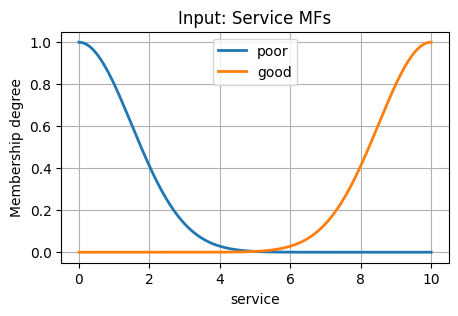

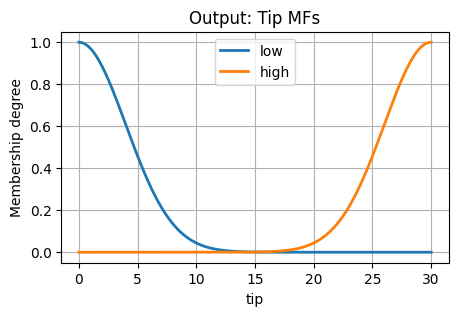

=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluation ===
=== Evaluation Completed ===
=== Starting FIS Evaluat

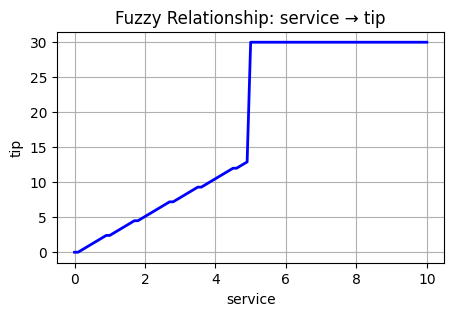

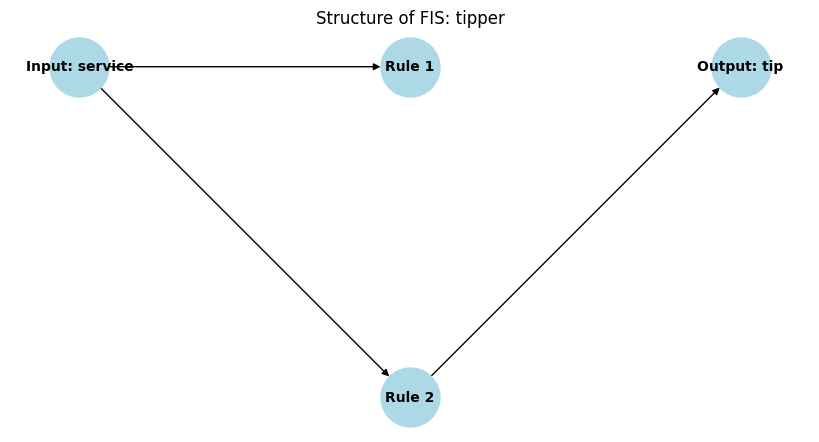


✅ 所有绘图功能已测试完毕！


In [31]:
# ============================================================
#   测试 FuzzyInferenceSystem：Defuzz + evalmf + Plot 功能
# ============================================================

fis = FuzzyInferenceSystem("tipper", defuzz_method="centroid")

# 输入变量 service ∈ [0, 10]
fis.add_variable("input", "service", (0, 10))
fis.add_mf("input", 0, "poor", "gaussmf", [1.5, 0])
fis.add_mf("input", 0, "good", "gaussmf", [1.5, 10])

# 输出变量 tip ∈ [0, 30]
fis.add_variable("output", "tip", (0, 30))
fis.add_mf("output", 0, "low", "gaussmf", [4, 0])
fis.add_mf("output", 0, "high", "gaussmf", [4, 30])

# 规则（两条）
fis.add_rule([2, 2, 1, 1])
fis.add_rule([1, 1, 1, 1])

# ------------------------------------------------------------
# 测试 defuzz 方法 + evalmf 输出
# ------------------------------------------------------------
input_value = 7.0
point_n = 101  

print("\n=== Defuzzification Methods + evalmf Check ===")
print(f"{'Method':<12s}{'Output':>12s}{'poor(7.0)':>14s}{'good(7.0)':>14s}")
print("-" * 54)

for m in ["centroid", "bisector", "mom", "som", "lom"]:
    fis.defuzz_method = m
    val = fis.eval([input_value], point_n=point_n)
    poor_mu = fis.evalmf(input_value, "gaussmf", [1.5, 0])
    good_mu = fis.evalmf(input_value, "gaussmf", [1.5, 10])

    print(f"{m:<12s}{val:>12.6f}{poor_mu.item():>14.4f}{good_mu.item():>14.4f}", flush=True)

print("-" * 54)

# ------------------------------------------------------------
# 绘图测试部分
# ------------------------------------------------------------
print("\n=== 绘图功能测试 (plotmf, plotvar, plot_graph) ===")

# 1️⃣ 绘制输入/输出隶属函数
fis.plotmf("input", 0, main="Input: Service MFs")
fis.plotmf("output", 0, main="Output: Tip MFs")

# 2️⃣ 绘制输入-输出模糊关系曲线
fis.plotvar(0)

# 3️⃣ 绘制系统结构图
fis.plot_graph()

print("\n✅ 所有绘图功能已测试完毕！")
